In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [2]:
diab = pd.read_csv("diabetes_explore2.csv") 
print (diab.head(10) )

diab.info()
print("aggregate statistics:")
diab.describe()

   preg  plas  pres  skin  insu  mass   pedi  age  class age_level
0     6   148    72    35     0  33.6  0.627   50      1       50s
1     1    85    66    29     0  26.6  0.351   31      0       30s
2     8   183    64     0     0  23.3  0.672   32      1       30s
3     1    89    66    23    94  28.1  0.167   21      0       20s
4     0   137    40    35   168  43.1  2.288   33      1       30s
5     5   116    74     0     0  25.6  0.201   30      0       30s
6     3    78    50    32    88  31.0  0.248   26      1       20s
7    10   115     0     0     0  35.3  0.134   29      0       20s
8     2   197    70    45   543  30.5  0.158   53      1       50s
9     8   125    96     0     0   0.0  0.232   54      1       50s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
preg         768 non-null int64
plas         768 non-null int64
pres         768 non-null int64
skin         768 non-null int64
insu         768 non-null int6

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
print(diab.age_level.unique())
print("counts of age_level:")
print(diab['age_level'].value_counts())

['50s' '30s' '20s' '40s' '60+']
counts of age_level:
20s    396
30s    165
40s    118
50s     57
60+     32
Name: age_level, dtype: int64


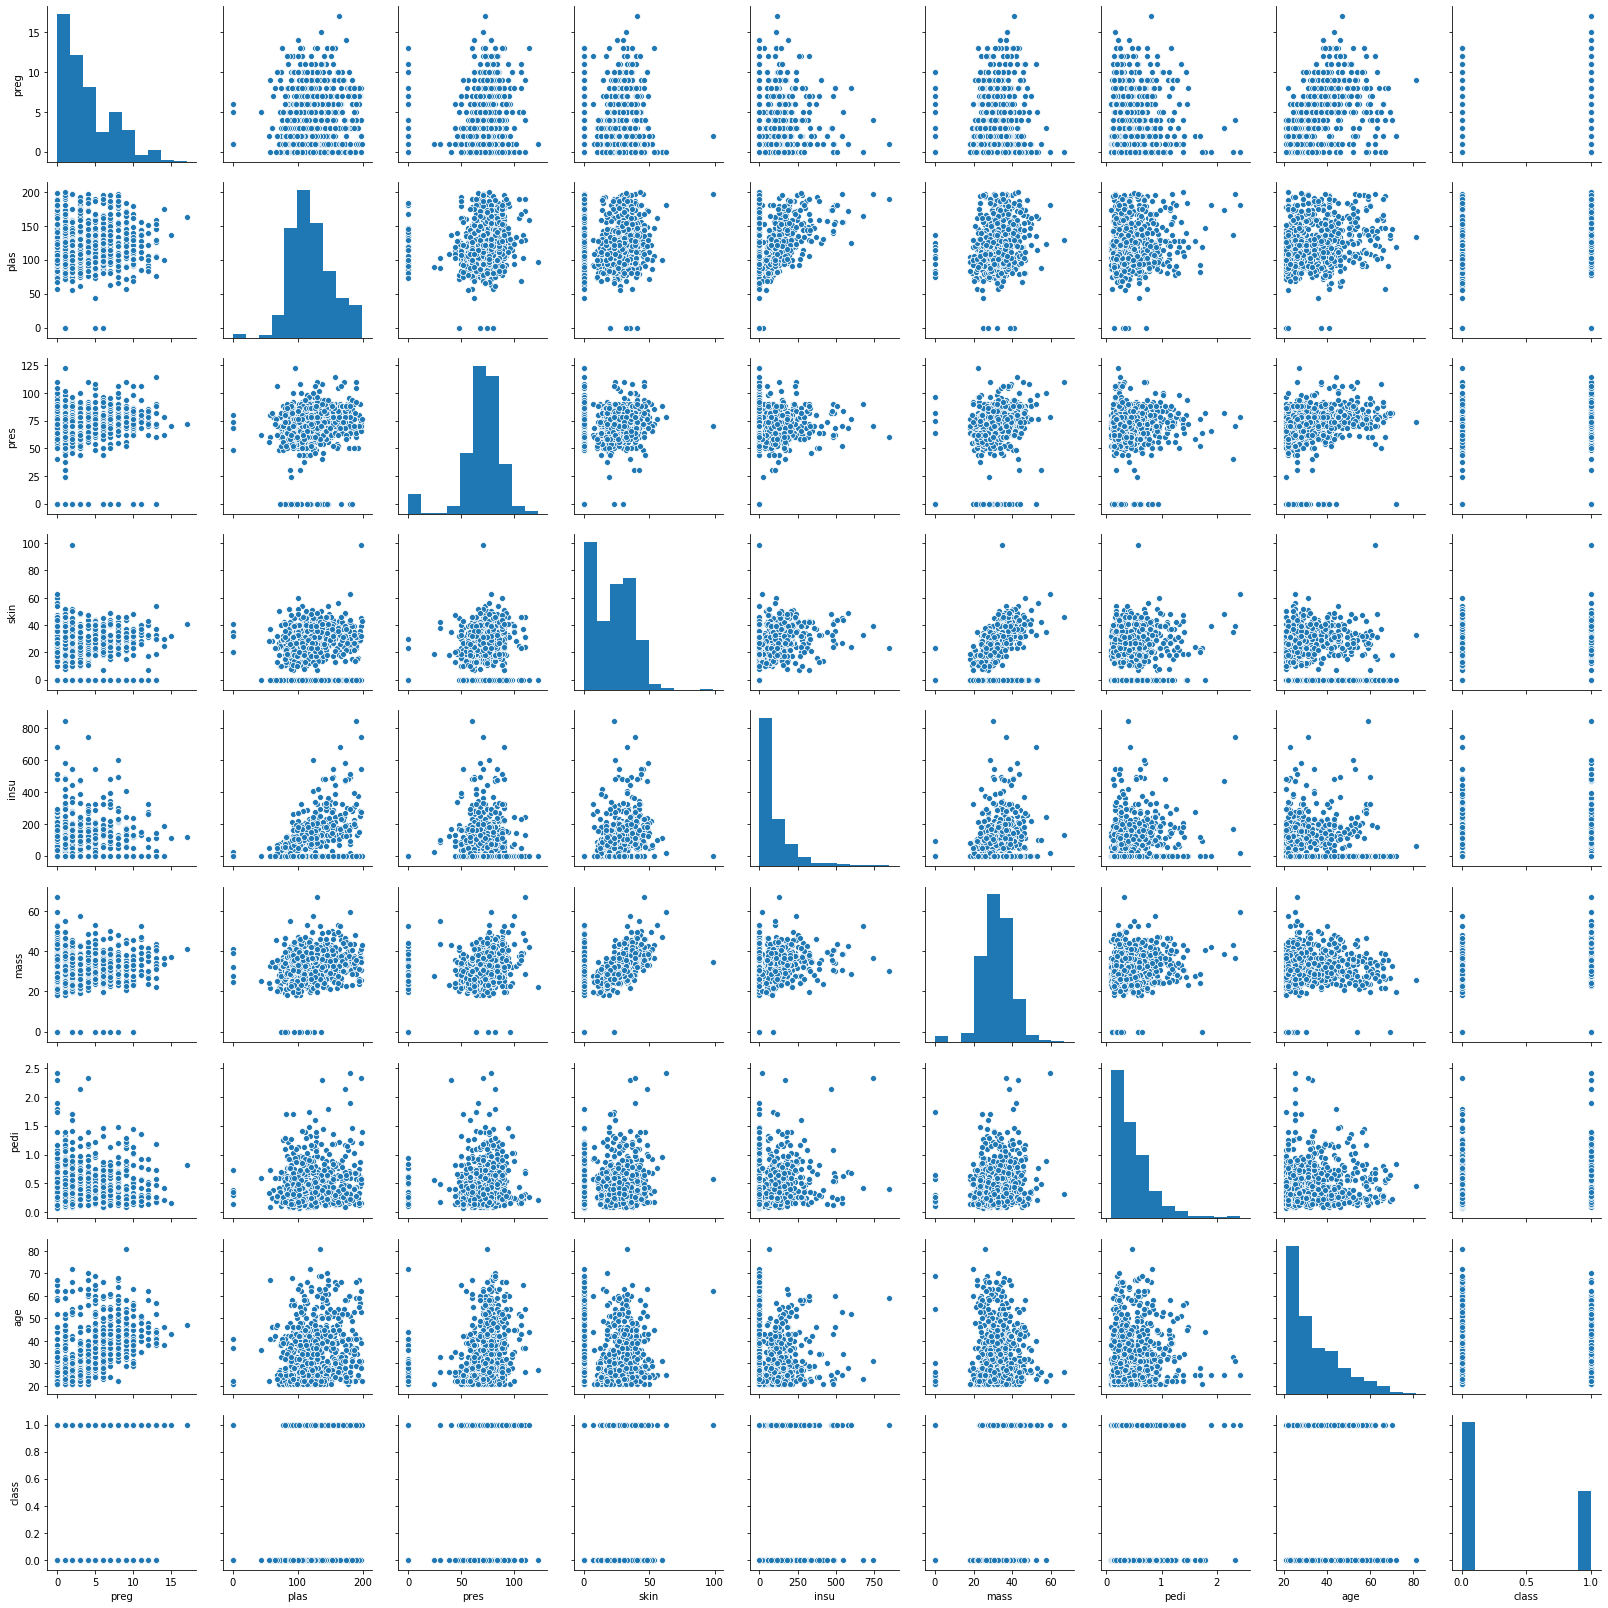

In [4]:
plot_diab = diab.dropna()
sns.pairplot(plot_diab)
# shows distribution of each variable

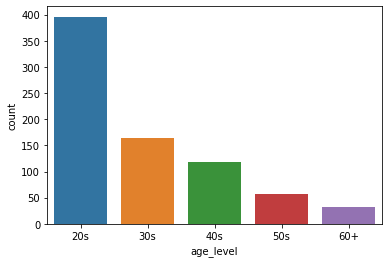

In [5]:
sns.countplot(x='age_level',data=diab, order=['20s','30s','40s','50s', '60+'])
# plots displays the count of observations in each age level groups

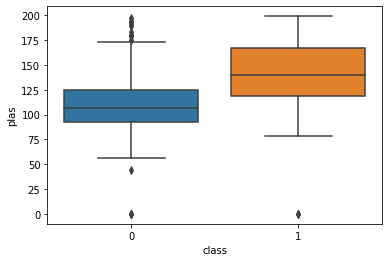

In [6]:
sns.boxplot(x="class", y="plas", data=diab)
# this plot indicates that observations with high plasma levels, tend to have diabetes over not having diabetes

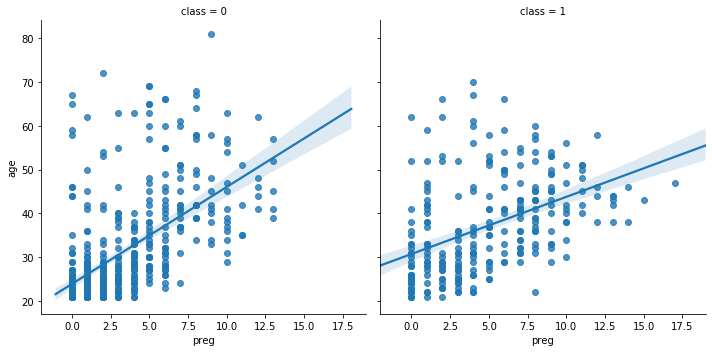

In [7]:
sns.lmplot(x="preg", y="age", data = diab, col="class")
# plot indicates that there isn't a very strong corelation between preg and age with having diabetes or not

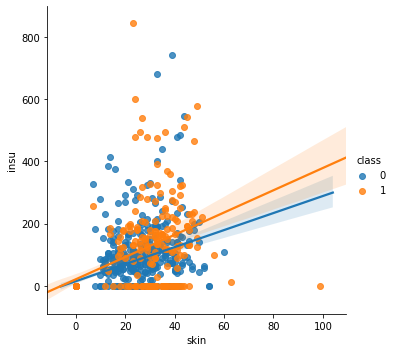

In [8]:
sns.lmplot( x="skin", y="insu", data=diab, fit_reg=True, hue='class')
# this plot indicates that people with higher insulin values and are also on higher skin values, which is an indicator of obesity,
# have a higher chance of having diabetes (class=1) as compared to other group of samples

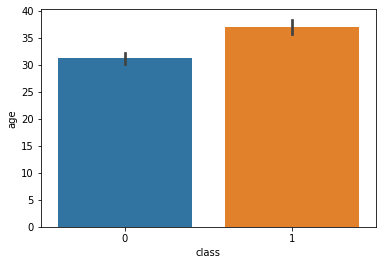

In [9]:
sns.barplot(x="class", y="age", data=diab)
# plot indicates that there is a the chances of having diabetes increases with an increase in the age

In [10]:
diab.corr(method="pearson")
# strong correlation pairs: insu & plas, insu & skin, mass & skin, age & preg, plas & class

,preg,plas,pres,skin,insu,mass,pedi,age,class
preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
plas,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
pres,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insu,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
mass,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedi,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
class,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [11]:
# data cleaning
# not cleaning preg= 17: assumption that mother can be pregnant 
# (pregnancies & miscarriages) 17 times is not impossible 
# plasma=0, pres=0, skin=0, insu=0, mass=0
diab1 = diab.copy(deep=True)
diab1['plas'] = diab1['plas'].replace(0,np.NaN)
diab1['pres'] = diab1['pres'].replace(0,np.NaN)
diab1['skin'] = diab1['skin'].replace(0,np.NaN)
diab1['insu'] = diab1['insu'].replace(0,np.NaN)
diab1['mass'] = diab1['mass'].replace(0,np.NaN)
print("aggregate statistics after data cleaning:")
diab1.describe()

aggregate statistics after data cleaning:


,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000
